In [2]:
## Add differences between conditions when estimating
# a) allow for multiple different gamma distris
# b) allow for different mags
# c) combination
# d) more than two conditions
# e) different numbers of bumps


# based on tutorial 3, so load data first

import os
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from mne.io import read_info
import matplotlib.pyplot as plt

import multiprocessing as mp

mp.set_start_method("fork")  # otherwise weird behavior

In [3]:
cpus = 12  # you can probably increase this :)

# Tutorial 3 data
#####################

epoch_data = xr.load_dataset(os.path.join("data/sat1/data.nc"))
epoch_data = epoch_data.sel(participant=["0021", "0022", "0023", "0024"])

In [4]:
# We create also the position array for the electrodes as we are going to need them to plot the event topologies
info = read_info(
    os.path.join("data/sat1/preprocessed/processed_0001_epo.fif"),
    verbose=False,
)

In [8]:
hmp_data = hmp.utils.transform_data(epoch_data, apply_zscore="participant", n_comp=4)

In [9]:
init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=cpus)

Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model


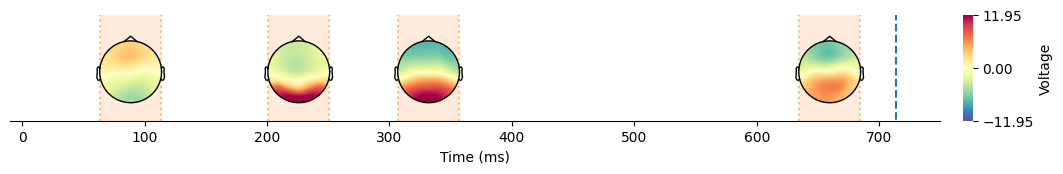

In [20]:
# Baseline: gets some useful mags and pars
#######################################################################

# calc estimates
estimate4 = init.fit_single(4)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    estimate4,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
)

mags4 = estimate4.magnitudes.data
pars4 = estimate4.parameters.data

In [11]:
# models
#######################################

# Conditions need to be specified as a dictionary with the name of the coordinates as the key
# and the levels as the values, e.g. {'cue': ['SP', 'AC'], or a list of such dictionaries, e.g.,
# [{'cue': ['SP', 'AC']}, {'resp': ['resp_left', 'resp_right']}] which are then crossed
# automatically. The combined levels correspond to the rows in the maps below.


# conditions
conds = {"cue": ["SP", "AC"]}
# conds = {"resp": ["resp_left", "resp_right"]}
# conds = [{"cue": ["SP", "AC"]}, {"resp": ["resp_left", "resp_right"]}]

Condition "cue" analyzed, with levels: ['SP', 'AC']

Coded as follows: 
0: ('SP',)
1: ('AC',)

Magnitudes map:
0:  [0 0 0 0]
1:  [0 0 0 0]

Parameters map:
0:  [0 0 0 0 0]
1:  [0 0 0 0 0]

Estimating 4 events model
parameters estimated for 4 events model


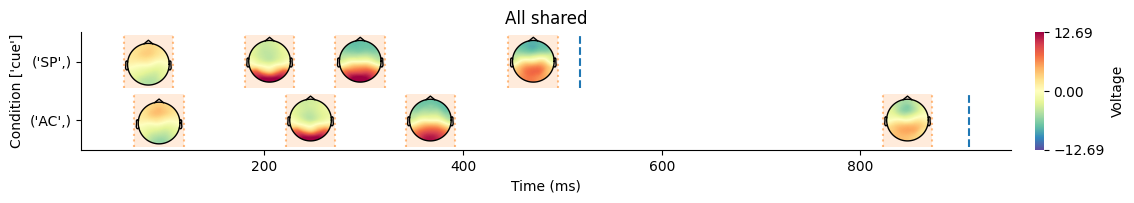

In [12]:
# First, completely shared events/gammas between conditions (similar to standard fit_single, but not identical):

# The maps indicate which parameters or magnitudes can differ between the
# condition levels. Here they are all the same. You can also only specify a
# pars_map or a mags_map, it then assumes the other ones are shared. The function
# prints condition levels and maps that are used.
pars_map = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])

mags_map = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])

stage_estimate = init.fit_single_conds(
    magnitudes=mags4, parameters=pars4, pars_map=pars_map, conds={"cue": ["SP", "AC"]}
)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    stage_estimate,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
    title="All shared",
)  # automatically plots the ylabels, can always be overwritten with a ylabels arg

Condition "cue" analyzed, with levels: ['SP', 'AC']

Coded as follows: 
0: ('SP',)
1: ('AC',)

Magnitudes map:
0:  [0 0 0 0]
1:  [1 1 1 1]

Parameters map:
0:  [0 0 0 0 0]
1:  [1 1 1 1 1]

Estimating 4 events model
parameters estimated for 4 events model


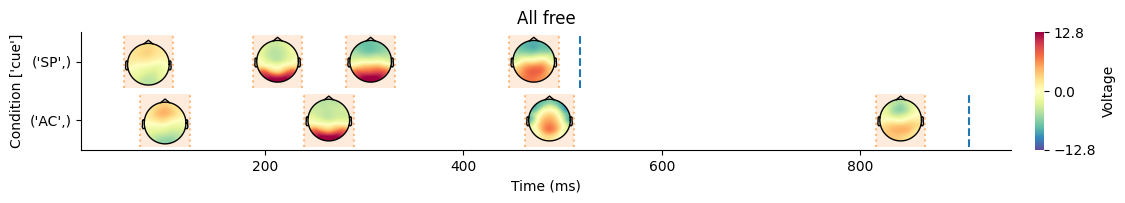

In [13]:
# This didn't give us a great fit, so let's see what happens when we let everything vary between  conditions:

# completely separate
pars_map = np.array([[0, 0, 0, 0, 0], [1, 1, 1, 1, 1]])

mags_map = np.array([[0, 0, 0, 0], [1, 1, 1, 1]])

stage_estimate = init.fit_single_conds(
    magnitudes=mags4,
    parameters=pars4,
    pars_map=pars_map,
    mags_map=mags_map,
    conds={"cue": ["SP", "AC"]},
)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    stage_estimate,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
    title="All free",
)

Condition "cue" analyzed, with levels: ['SP', 'AC']

Coded as follows: 
0: ('SP',)
1: ('AC',)

Magnitudes map:
0:  [0 0 0 0]
1:  [0 0 1 0]

Parameters map:
0:  [0 0 0 0 0]
1:  [0 0 0 1 0]

Estimating 4 events model
parameters estimated for 4 events model


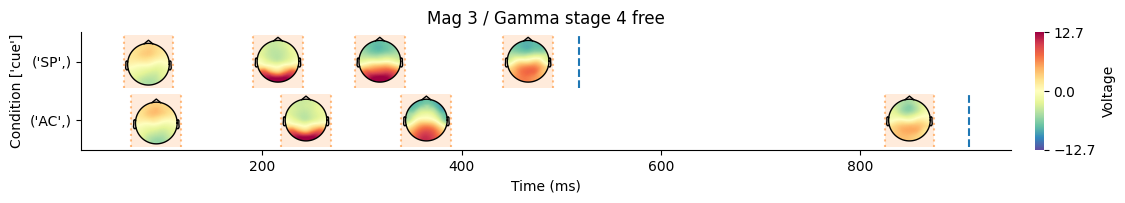

In [14]:
# That's a bit better, but many things seems shared. So what about we only let magnitude three be different, and the gamma
# between stage 4 and 5?

pars_map = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 1, 0]])
mags_map = np.array([[0, 0, 0, 0], [0, 0, 1, 0]])

stage_estimate = init.fit_single_conds(
    magnitudes=mags4,
    parameters=pars4,
    pars_map=pars_map,
    mags_map=mags_map,
    conds={"cue": ["SP", "AC"]},
)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    stage_estimate,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
    title="Mag 3 / Gamma stage 4 free",
)

# This involves way fewer parameters, but I still have to implement LOOCV to see if it's not a worse fit.

Condition "cue" analyzed, with levels: ['SP', 'AC']

Coded as follows: 
0: ('SP',)
1: ('AC',)

Magnitudes map:
0:  [ 0  0 -1  0]
1:  [0 0 0 0]

Parameters map:
0:  [ 0  0 -1  0  0]
1:  [0 0 0 1 0]

-----
Negative parameters. Note that this stage is left out, while the parameters
of the other stages are compared column by column. In this parameter map example:
[[ 0  0  0  0]
 [ 0 -1  0  0]]
the parameters of stage 1 are shared, as well as the parameters of stage 3 of
condition 1 with stage 2 (column 3) of condition 2 and the last stage of both
conditions.
Given that event 2 is probably missing in condition 2, it would typically
make more sense to let both stages around event 2 in condition 1 vary as
compared to condition 2:
[[ 0  0  0  0]
 [ 0 -1  1  0]]
-----

Estimating 4 events model
parameters estimated for 4 events model


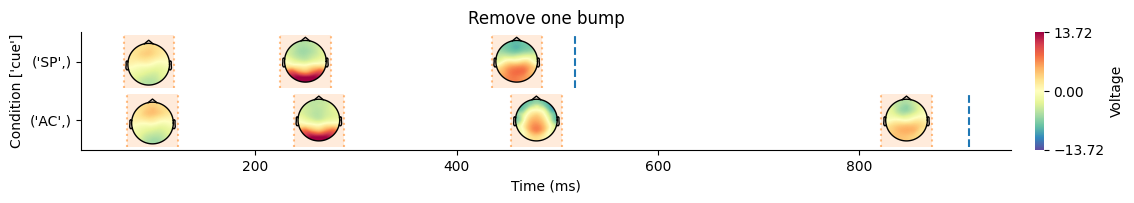

In [19]:
# However, we 'know' bump 3 in speed is spurious. We can also just leave it out, which means the gamma before disappears:
# (I should add an assertion that this goes correctly). In addition, the penultimate gamma can vary (also this I need to check).

pars_map = np.array([[0, 0, -1, 0, 0], [0, 0, 0, 1, 0]])
mags_map = np.array([[0, 0, -1, 0], [0, 0, 0, 0]])

stage_estimate = init.fit_single_conds(
    magnitudes=mags4,
    parameters=pars4,
    pars_map=pars_map,
    mags_map=mags_map,
    conds={"cue": ["SP", "AC"]},
)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    stage_estimate,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
    title="Remove one bump",
)

Condition "cue" analyzed, with levels: ['SP', 'AC']
Condition "resp" analyzed, with levels: ['resp_left', 'resp_right']

Coded as follows: 
0: ('SP', 'resp_left')
1: ('SP', 'resp_right')
2: ('AC', 'resp_left')
3: ('AC', 'resp_right')

Magnitudes map:
0:  [ 0  0 -1  0]
1:  [ 0  0 -1  1]
2:  [0 0 0 0]
3:  [0 0 0 1]

Parameters map:
0:  [ 0  0 -1  0  0]
1:  [ 0  0 -1  0  0]
2:  [0 0 0 1 0]
3:  [0 0 0 1 0]

-----
Negative parameters. Note that this stage is left out, while the parameters
of the other stages are compared column by column. In this parameter map example:
[[ 0  0  0  0]
 [ 0 -1  0  0]]
the parameters of stage 1 are shared, as well as the parameters of stage 3 of
condition 1 with stage 2 (column 3) of condition 2 and the last stage of both
conditions.
Given that event 2 is probably missing in condition 2, it would typically
make more sense to let both stages around event 2 in condition 1 vary as
compared to condition 2:
[[ 0  0  0  0]
 [ 0 -1  1  0]]
-----

Estimating 4 events 

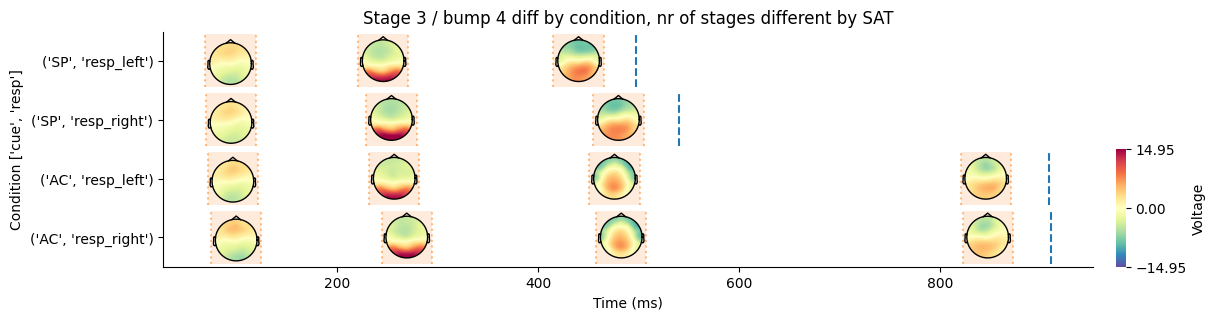

In [16]:
# Finally, we can combine multiple conditions, where the speeded conditions have one bump less, and the right and left responses
# have separate magnitudes:

pars_map = np.array(
    [[0, 0, -1, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0]]
)

mags_map = np.array([[0, 0, -1, 0], [0, 0, -1, 1], [0, 0, 0, 0], [0, 0, 0, 1]])

stage_estimate = init.fit_single_conds(
    magnitudes=mags4,
    parameters=pars4,
    pars_map=pars_map,
    mags_map=mags_map,
    conds=[{"cue": ["SP", "AC"]}, {"resp": ["resp_left", "resp_right"]}],
)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    stage_estimate,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
    title="Stage 3 / bump 4 diff by condition, nr of stages different by SAT",
)

Condition "cue" analyzed, with levels: ['SP', 'AC']
Condition "resp" analyzed, with levels: ['resp_left', 'resp_right']

Coded as follows: 
0: ('SP', 'resp_left')
1: ('SP', 'resp_right')
2: ('AC', 'resp_left')
3: ('AC', 'resp_right')

Magnitudes map:
0:  [ 1  0 -1  0]
1:  [ 2  0 -1  1]
2:  [3 0 0 0]
3:  [4 0 0 1]

Parameters map:
0:  [ 0  0 -1  0  0]
1:  [ 0  0 -1  0  0]
2:  [0 0 0 1 0]
3:  [0 0 0 1 0]

-----
Negative parameters. Note that this stage is left out, while the parameters
of the other stages are compared column by column. In this parameter map example:
[[ 0  0  0  0]
 [ 0 -1  0  0]]
the parameters of stage 1 are shared, as well as the parameters of stage 3 of
condition 1 with stage 2 (column 3) of condition 2 and the last stage of both
conditions.
Given that event 2 is probably missing in condition 2, it would typically
make more sense to let both stages around event 2 in condition 1 vary as
compared to condition 2:
[[ 0  0  0  0]
 [ 0 -1  1  0]]
-----

Estimating 4 events 

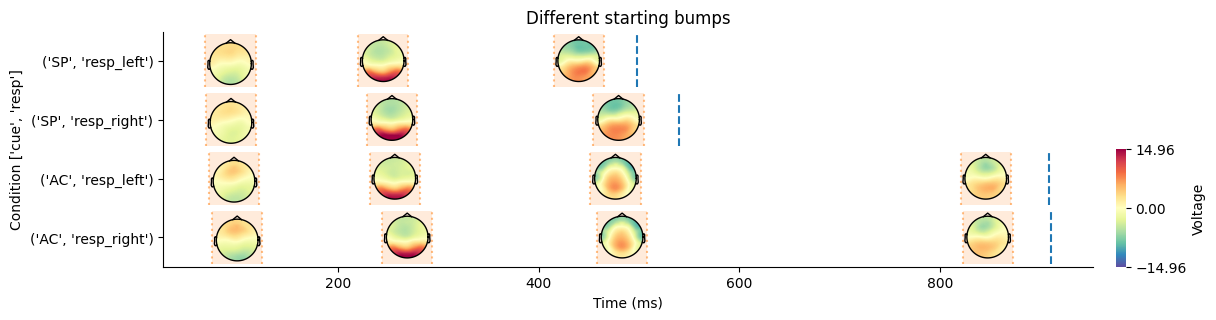

In [17]:
# Here not necessary, but you could also use 4 different magnitudes (here for the first event):
pars_map = np.array(
    [[0, 0, -1, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0]]
)

mags_map = np.array([[1, 0, -1, 0], [2, 0, -1, 1], [3, 0, 0, 0], [4, 0, 0, 1]])

stage_estimate = init.fit_single_conds(
    magnitudes=mags4,
    parameters=pars4,
    pars_map=pars_map,
    mags_map=mags_map,
    conds=[{"cue": ["SP", "AC"]}, {"resp": ["resp_left", "resp_right"]}],
)
hmp.visu.plot_topo_timecourse(
    epoch_data,
    stage_estimate,
    info,
    init,
    magnify=1,
    sensors=False,
    time_step=1000 / init.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
    title="Different starting bumps",
)